In [37]:
import boto3
import json
import pandas as pd
import re

bucket = "ubs-homes"
path = "erasmus/raj/dlproject/experiments/experiment_local/"

s3 = boto3.client("s3")

def load_json(bucket, key):
    """Load a JSON file from S3."""
    obj = s3.get_object(Bucket=bucket, Key=key)
    return json.loads(obj["Body"].read())

def list_s3_jsons(bucket, path, suffix=".json"):
    """Iterate over JSON files in an S3 path."""
    paginator = s3.get_paginator("list_objects_v2")
    for page in paginator.paginate(Bucket=bucket, Prefix=path):
        for obj in page.get("Contents", []):
            if obj["Key"].endswith(suffix):
                yield obj["Key"]

def create_dataframe(bucket, suffix, parser, path):
    """Create a DataFrame from JSON files in S3."""
    records = []
    for key in list_s3_jsons(bucket, path, suffix):
        record = parser(bucket, key)
        if record:
            records.append(record)
    return pd.DataFrame(records)


In [38]:
def parse_training_record(bucket, key):
    """Parse a training record from a JSON file."""
    data = load_json(bucket, key)
    parts = key.split("/")
    if len(parts) < 7 or not parts[6].startswith("frac_"):
        return None
    fraction = float(parts[6].replace("frac_", ""))
    if fraction < 0.001:
        return None

    num_gpus = int(re.search(r"train_(\d+)gpu", key).group(1))
    steps = {s["name"]: s for s in data["steps"]}

    return {
        "fraction": fraction,
        "num_gpus": num_gpus,
        "batch_size": data["summary"]["global_batch_size"],
        "total_time": data["summary"]["total_duration"],
        "train_time": steps["training"]["duration"],
        "test_time": steps["evaluation"]["duration"],
        "test_accuracy": data["summary"]["test_accuracy"],
    }

df_training = create_dataframe(bucket, "gpu_profile.json", parse_training_record, path)
df_training = df_training.sort_values(["fraction", "num_gpus"])  # sort
df_training


,fraction,num_gpus,batch_size,total_time,train_time,test_time,test_accuracy
0,0.01,1,16,206.042611,186.054617,9.536014,0.318222
1,0.01,2,32,143.468011,126.960531,5.558041,0.430928
2,0.01,4,64,155.318264,128.032053,8.737277,0.402334
3,0.03,1,16,512.987472,490.485912,12.634722,0.508294
4,0.03,2,32,315.110624,291.226785,12.772821,0.502318
5,0.03,4,64,269.370696,243.495944,14.288560,0.500733
6,0.05,1,16,833.484397,802.893747,19.990557,0.523459
7,0.05,2,32,502.083579,473.978798,17.921447,0.527239
8,0.05,4,64,392.059210,364.928554,16.563568,0.519124
9,0.10,1,16,1636.607833,1555.464665,70.863433,0.552079


In [39]:
def parse_conversion_record(bucket, key):
    """Parse a conversion record from a JSON file."""
    data = load_json(bucket, key)
    parts = key.split("/")
    if len(parts) < 7 or not parts[6].startswith("frac_"):
        return None
    fraction = float(parts[6].replace("frac_", ""))
    if fraction < 0.001:
        return None

    steps = {s["name"]: s for s in data["steps"]}
    return {
        "fraction": fraction,
        "total_time": data["summary"]["total_duration"],
        "read_metadata": steps["read_metadata"]["duration"],
        "spark_init": steps["spark_init"]["duration"],
        "write_train": steps["write_train"]["duration"],
        "write_validation": steps["write_validation"]["duration"],
        "write_test": steps["write_test"]["duration"],
        "train_samples": data["summary"]["train_samples"],
        "validation_samples": data["summary"]["validation_samples"],
        "test_samples": data["summary"]["test_samples"],
        "train_partitions": data["summary"]["train_partitions"],
        "validation_partitions": data["summary"]["validation_partitions"],
        "test_partitions": data["summary"]["test_partitions"],
    }


df_conversion = create_dataframe(bucket, "conversion_profile.json", parse_conversion_record, path)
df_conversion = df_conversion.sort_values("fraction")
df_conversion

,fraction,total_time,read_metadata,spark_init,write_train,write_validation,write_test,train_samples,validation_samples,test_samples,train_partitions,validation_partitions,test_partitions
0,0.01,1511.968416,68.706134,0.665045,605.462051,377.997149,459.138037,2379,1223,1198,16,8,8
1,0.03,3784.276087,65.787065,0.676562,1748.840913,969.199109,999.772439,7136,3670,3595,49,25,24
2,0.05,5690.076660,42.828149,0.658760,2823.524011,1370.739984,1452.325755,11894,6117,5991,82,42,41
3,0.10,10480.619844,63.758691,0.624710,4817.666250,3074.845983,2523.724210,23787,12234,11982,164,84,82


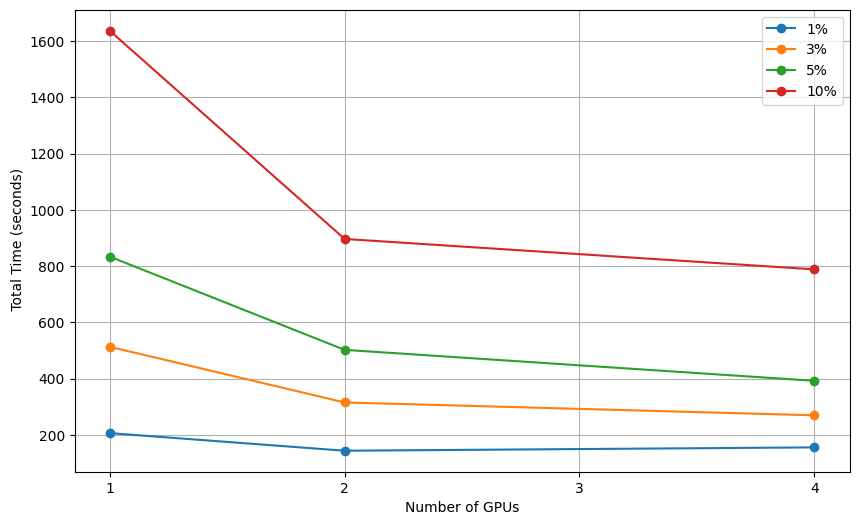

In [48]:
import matplotlib.pyplot as plt

# Plot training curves for each fraction
plt.figure(figsize=(10, 6))
for fraction, group in df_training.groupby("fraction"):
    plt.plot(
        group["num_gpus"],
        group["total_time"].values,
        marker="o",
        label=f"{fraction*100:.0f}%" ,
    )

plt.xlabel("Number of GPUs")
plt.xticks([1, 2, 3, 4])
plt.ylabel(" Total Time (seconds)")
plt.grid(True)
plt.legend()
plt.show()



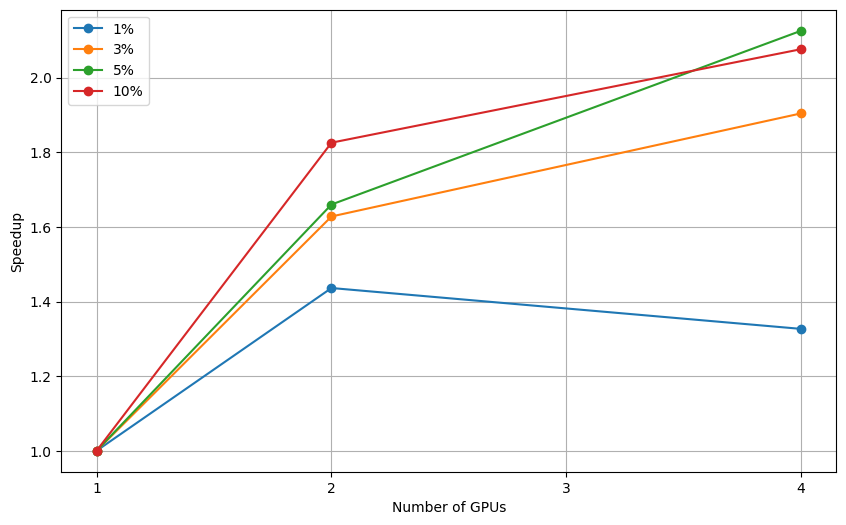

In [47]:
# Calculate speedup for training data
time_1gpu = df_training[df_training["num_gpus"] == 1].set_index("fraction")["total_time"]
df_training["speedup"] = df_training["fraction"].map(time_1gpu) / df_training["total_time"]

# Plot speedup curves 
plt.figure(figsize=(10, 6))
for fraction, group in df_training.groupby("fraction"):
    plt.plot(
        group["num_gpus"],
        group["speedup"],
        marker="o",
        label=f"{fraction*100:.0f}%",
    )

plt.xlabel("Number of GPUs")
plt.xticks([1, 2, 3, 4])
plt.ylabel("Speedup")
plt.grid(True)
plt.legend()
plt.show()

